[View in Colaboratory](https://colab.research.google.com/github/fickas/mccain/blob/master/keras_2_6_clipped.ipynb)

# clipped means clipped duration to 51. max should be 50 once call is placed.




<ul>
<li>Regression is done using different loss functions than what we used for classification. Mean squared error (MSE) is a loss function commonly used for regression.
<li>Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally, the concept of accuracy doesn’t apply for regression. A common regression metric is mean absolute error (MAE).
<li>When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
<li>When there is little data available, using K-fold validation is a great way to reliably evaluate a model.
<li>When little training data is available, it’s preferable to use a small network with few hidden layers (typically only one or two), in order to avoid severe overfitting.
  </ul>




In [55]:
%%html
<style>
.h1_cell, .just_text {
    box-sizing: border-box;
    padding-top:5px;
    padding-bottom:5px;
    font-family: "Times New Roman", Georgia, Serif;
    font-size: 125%;
    line-height: 22px; /* 5px +12px + 5px */
    text-indent: 25px;
    background-color: #fbfbea;
    padding: 10px;
}

hr { 
    display: block;
    margin-top: 0.5em;
    margin-bottom: 0.5em;
    margin-left: auto;
    margin-right: auto;
    border-style: inset;
    border-width: 2px;
}
</style>

<h1>
<font color="blue">My comments in blue</font>
</h1>
<div class=h1_cell>
<p>
I rewrote major portions of your code to make it simpler and run faster. See my comments with blue font and yellow background on text.
<p>
Maybe first thing to note is that I switched from 3.6 to 2.7. This is not a criticism of you using 3.6. We did not specify what version to use.
</div>
<hr>

In [0]:
#get data

import pandas as pd

In [0]:
df_26 = pd.read_csv('https://www.dropbox.com/s/380v7h7v9547dbe/df_26.csv?raw=1')

In [4]:
df_26.head()

,month,day,dow,hour,minute,second,this_duration,last_phase,last_26_duration
0,7.0,19.0,3.0,14.0,35.0,29.0,15.0,2.0,NaN
1,7.0,19.0,3.0,14.0,36.0,4.0,22.0,3.0,15.0
2,7.0,19.0,3.0,14.0,37.0,3.0,13.0,5.0,22.0
3,7.0,19.0,3.0,14.0,37.0,32.0,10.0,2.0,13.0
4,7.0,19.0,3.0,14.0,37.0,56.0,17.0,1.0,10.0


In [5]:
df_26 = df_26[1:]
df_26.head()

,month,day,dow,hour,minute,second,this_duration,last_phase,last_26_duration
1,7.0,19.0,3.0,14.0,36.0,4.0,22.0,3.0,15.0
2,7.0,19.0,3.0,14.0,37.0,3.0,13.0,5.0,22.0
3,7.0,19.0,3.0,14.0,37.0,32.0,10.0,2.0,13.0
4,7.0,19.0,3.0,14.0,37.0,56.0,17.0,1.0,10.0
5,7.0,19.0,3.0,14.0,38.0,26.0,13.0,2.0,17.0


In [6]:
df_26.describe()

,month,day,dow,hour,minute,second,this_duration,last_phase,last_26_duration
count,777.0,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000
mean,7.0,19.813385,3.813385,14.182754,29.467181,29.039897,107.207207,2.759331,107.207207
std,0.0,0.615459,0.615459,2.089508,17.466367,17.243024,1439.550494,1.477492,1439.550494
min,7.0,19.000000,3.000000,10.000000,0.000000,0.000000,6.000000,0.000000,6.000000
25%,7.0,19.000000,3.000000,13.000000,15.000000,15.000000,13.000000,2.000000,13.000000
50%,7.0,20.000000,4.000000,15.000000,29.000000,28.000000,21.000000,2.000000,21.000000
75%,7.0,20.000000,4.000000,16.000000,45.000000,44.000000,29.000000,5.000000,29.000000
max,7.0,21.000000,5.000000,23.000000,59.000000,59.000000,39119.000000,5.000000,39119.000000


In [0]:
#month is constant (std is 0). Drop it.

df_26 = df_26.drop('month', axis=1)

In [0]:
#clip duration at 51. Reason is that 50 is longest it will be active *given* a call from other phase.

df_26['this_duration'][df_26['this_duration'] >= 51.] = 51.
df_26['last_26_duration'][df_26['last_26_duration'] >= 51.] = 51.  #this means need to rebuild input data

In [0]:
df_train = df_26[:600]
df_test = df_26[600:]

In [0]:
train_target = df_train['this_duration'].values

In [11]:
train_target.shape

(600,)

In [0]:
df_train = df_train.drop('this_duration', axis=1)

In [0]:
train_input = df_train.values

In [14]:
train_input.shape

(600, 7)

In [0]:
test_target = df_test['this_duration'].values

In [0]:
df_test = df_test.drop('this_duration', axis=1)

In [0]:
test_input = df_test.values

```
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
```

```
#for each feature, take mean, subtract mean to get a mean of 0, then divide by std to get std of 1
#numpy makes it easy to map these operations across all features.


mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

print(train_data[:10])
print(test_data[:10])
```

In [19]:
print(train_input[0][:10])
mean = train_input.mean(axis=0)
train_input -= mean
print(train_input[0][:10])

[19.  3. 14. 36.  4.  3. 15.]
[ -0.61166667  -0.61166667  -0.3          6.56       -24.75333333
   0.11333333  -7.29166667]


In [20]:
std = train_input.std(axis=0)
train_input /= std
print(train_input[0][:10])

[-1.25503279 -1.25503279 -0.18545863  0.37465143 -1.44650226  0.07526915
 -0.70911087]


In [21]:
std

array([ 0.48737107,  0.48737107,  1.61761141, 17.50960879, 17.11254381,
        1.50570766, 10.28283021])

In [22]:
print(test_input[0][:10])
mean = test_input.mean(axis=0)
test_input -= mean
print(test_input[0][:10])

[20.  4. 16. 22.  5.  2. 15.]
[ -0.49717514  -0.49717514   2.21468927  -7.55932203 -25.01129944
  -0.32768362  -8.69491525]


In [23]:
std = test_input.std(axis=0)
test_input /= std
print(test_input[0][:10])

[-0.99436615 -0.99436615  0.69801517 -0.43774366 -1.4214277  -0.25556365
 -0.64210738]


In [24]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_input.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


Using TensorFlow backend.


In [25]:
import numpy as np

k = 4
num_val_samples = len(train_input) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_input[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_target[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_input[:i * num_val_samples],
         train_input[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_target[:i * num_val_samples],
         train_target[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [26]:
all_scores
#[2.588258957792037, 3.1289568449719116, 3.1856116051248984, 3.0763342615401386]


[11.510405820210774, 10.646002184549967, 9.709976387023925, 10.269716135660808]

In [27]:
np.mean(all_scores)
#2.9947904173572462

10.53402513186137

In [28]:
#try for 500 epochs and more monitoring

num_epochs = 250

all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_input[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_target[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_input = np.concatenate(
        [train_input[:i * num_val_samples],
         train_input[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_target[:i * num_val_samples],
         train_target[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [29]:
all_mae_histories[0][:10]

[8.853803876241049,
 9.290015767415365,
 9.245444501241048,
 9.227819379170736,
 9.12681027730306,
 9.159519373575847,
 8.945298728942872,
 9.19935915629069,
 9.317804476420084,
 9.502103449503581]

In [0]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

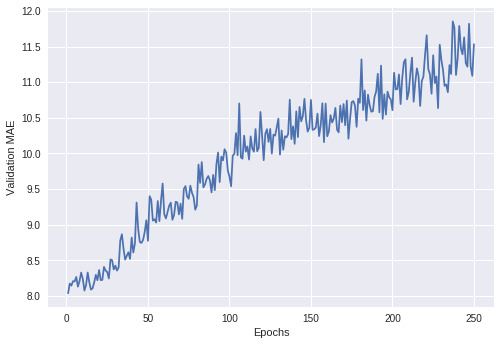

In [31]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

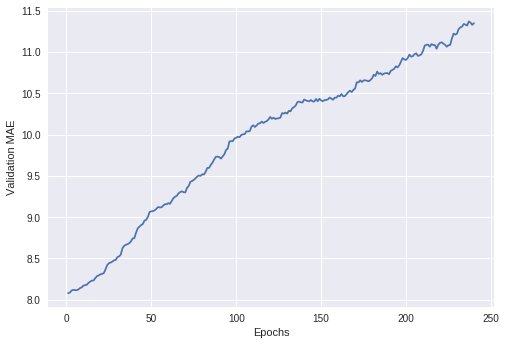

In [32]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [33]:
#now that know where to set epochs, go back and train on full training data.

new_epochs = 20
batch_size = 1

model = build_model()
model.fit(train_input, train_target,
          epochs=new_epochs, batch_size=batch_size, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_input, test_target)



177/177 [==============================] - 0s 644us/step


In [34]:
print((test_mse_score, test_mae_score))

(183.6587974419028, 11.185988097541076)


In [37]:
model = build_model()
model.fit(train_input, train_target,
          epochs=20, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_input, test_target)

test_mae_score

177/177 [==============================] - 0s 840us/step


10.891290675448833

In [0]:
predictions = model.predict(test_input)

In [39]:
predictions[:10]

array([[18.62755 ],
       [17.62868 ],
       [17.773882],
       [18.456469],
       [23.432985],
       [17.679962],
       [19.109148],
       [17.704727],
       [17.191616],
       [19.793732]], dtype=float32)

In [0]:
diffs = []
for i in range(len(test_target)):
  actual = test_target[i]
  pred = predictions[i][0]
  diffs.append(pred-actual)
          

In [41]:
diffs[:10]  #negative is under-estimating

[5.62755012512207,
 -16.371320724487305,
 -0.2261180877685547,
 1.4564685821533203,
 -8.567014694213867,
 4.679962158203125,
 9.109148025512695,
 -9.295272827148438,
 7.191616058349609,
 -10.206268310546875]

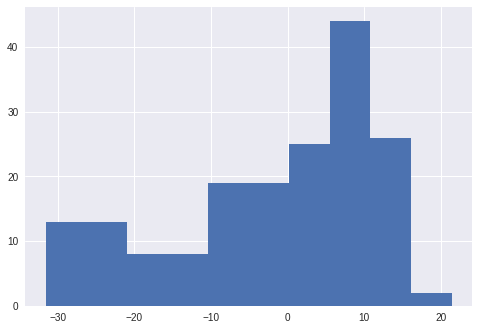

In [46]:

plt.hist(diffs)
plt.show()

In [52]:
over = [x for x in diffs if x>0]
over_average = sum(over)/len(over)
over_average

8.198202911688357

In [53]:
under = [x for x in diffs if x<0]
under_average = sum(under)/len(under)
under_average

-14.232082197937784

predict less than actual at average of 14.23. Rider has to wait longer than we predict.

Not so good.

Both are roughly equal in terms of numbers of over and under predictions.

In [54]:
(len(over),len(under))  #over predicting at roughly 10% more

(98, 79)

GET MORE DATA BEFORE MESSING WITH HYPER PARAMS